In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
from data_utils import get_train_batch, get_val_batch, get_test_batch
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, BatchNormalization, Flatten, Activation
from keras.models import Sequential, Model, load_model
from keras import optimizers, metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import LSTM, Lambda, TimeDistributed, GRU, RepeatVector, CuDNNGRU

Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def plot_image(image, shape=[64, 64, 3]):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")

def plot_images(images, num_images):
    fig = plt.figure(figsize=(24, 8))
    for i in range(0, num_images):
        fig.add_subplot(num_images//5, 5, i+1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

In [3]:
encoder = load_model('./models/Encoder_0616_256.hdf5')
decoder = load_model('./models/Decoder_0616_256.hdf5')
model = load_model('./models/model0616_256_60epoch.hdf5')
encoder.trainable = False
decoder.trainable = False
encoder.summary()
decoder.summary()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)           

In [4]:
dim = 4*4*16

time_steps = 10;
num_outputs = 10;
n_train = 20000
n_val = 500

val_input_batch = np.empty(shape = (n_val*2, time_steps, dim), dtype = np.float32)
val_output_batch = np.empty(shape = (n_val*2, num_outputs, dim), dtype = np.float32)
for i in range(n_val):
    inputs, outputs = get_val_batch(i, i+1)
    inputs = np.reshape(inputs, (-1, 64, 64, 3))
    temp = encoder.predict_on_batch(inputs)
    temp = temp[None, :, :]
    val_input_batch[i] = temp
    outputs = np.reshape(outputs, (-1, 64, 64, 3))
    temp = encoder.predict_on_batch(outputs)
    temp = temp[None, :, :]
    val_output_batch[i] = temp
for i in range(n_val):
    outputs, inputs = get_val_batch(i, i+1)
    inputs = np.reshape(inputs, (-1, 64, 64, 3))
    inputs = np.flip(inputs, 0)
    temp = encoder.predict_on_batch(inputs)
    temp = temp[None, :, :]
    val_input_batch[n_val+i] = temp
    outputs = np.reshape(outputs, (-1, 64, 64, 3))
    outputs = np.flip(outputs, 0)
    temp = encoder.predict_on_batch(outputs)
    temp = temp[None, :, :]
    val_output_batch[n_val+i] = temp

In [7]:
def image_augmentation(inputs, outputs, opt, time_steps = 10):
    inputs_ = np.zeros_like(inputs, dtype = np.float32)
    outputs_ = np.zeros_like(outputs, dtype = np.float32)
    if opt == 0:
        inputs_ = inputs
        outputs_ = outputs
    elif opt == 1:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = inputs[i][:-6, :-6]
            outputs_[i][3:61, 3:61] = outputs[i][:-6, :-6]
    elif opt == 2:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = inputs[i][6:, :-6]
            outputs_[i][3:61, 3:61] = outputs[i][6:, :-6]
    elif opt == 3:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = inputs[i][6:, 6:]
            outputs_[i][3:61, 3:61] = outputs[i][6:, 6:]
    elif opt == 4:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = inputs[i][:-6, 6:]
            outputs_[i][3:61, 3:61] = outputs[i][:-6, 6:]
    elif opt == 5:
        for i in range(time_steps):
            inputs_[i][:-6, :-6] = inputs[i][3:61, 3:61]
            outputs_[i][:-6, :-6] = outputs[i][3:61, 3:61]
    elif opt == 6:
        for i in range(time_steps):
            inputs_[i][6:, :-6] = inputs[i][3:61, 3:61]
            outputs_[i][6:, :-6] = outputs[i][3:61, 3:61]
    elif opt == 7:
        for i in range(time_steps):
            inputs_[i][6:, 6:] = inputs[i][3:61, 3:61]
            outputs_[i][6:, 6:] = outputs[i][3:61, 3:61]
    elif opt == 8:
        for i in range(time_steps):
            inputs_[i][:-6, 6:] = inputs[i][3:61, 3:61]
            outputs_[i][:-6, 6:] = outputs[i][3:61, 3:61]
    return inputs_, outputs_

def batch_data_generator_for_LSTM(batch_size):
    while(True):
        input_batch = np.empty(shape = (batch_size, time_steps, dim), dtype = np.float32)
        output_batch = np.empty(shape = (batch_size, num_outputs, dim), dtype = np.float32)
        for i in range(batch_size):
            if np.random.randint(0,2) == 0:
                inputs, outputs = get_train_batch(1)
                inputs = np.reshape(inputs, (-1, 64, 64, 3))
                outputs = np.reshape(outputs, (-1, 64, 64, 3))
                temp = encoder.predict_on_batch(inputs)
                temp = temp[None, :, :]
                input_batch[i] = temp
                temp = encoder.predict_on_batch(outputs)
                temp = temp[None, :, :]
                output_batch[i] = temp
            else:
                outputs, inputs = get_train_batch(1)
                inputs = np.reshape(inputs, (-1, 64, 64, 3))
                inputs = np.flip(inputs, 0)
                outputs = np.reshape(outputs, (-1, 64, 64, 3))
                outputs = np.flip(outputs, 0)
                temp = encoder.predict_on_batch(inputs)
                temp = temp[None, :, :]
                input_batch[i] = temp
                temp = encoder.predict_on_batch(outputs)
                temp = temp[None, :, :]
                output_batch[i] = temp
        yield input_batch, output_batch

def schedule(epoch, lr):
    decay_rate = 0.5
    decay_step = 100
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr
        
def show_outputs(data_type = 'train', index = 0, is_plotting = True):
    if data_type == 'train':
        inputs, answers = get_train_batch(1)
        inputs = np.reshape(inputs, (-1, 64, 64, 3))
        answers = np.reshape(answers, (-1, 64, 64, 3))
        encoded_inputs = encoder.predict_on_batch(inputs)
        encoded_inputs = encoded_inputs[None, :, :]
        features = model.predict_on_batch(encoded_inputs)
        features = np.reshape(features, (-1, dim))
        outputs = decoder.predict_on_batch(features)
    elif data_type == 'validation':
        inputs, answers = get_val_batch(index, index+1)
        answers = np.reshape(answers, (-1, 64, 64, 3))
        encoded_inputs = encoder.predict_on_batch(inputs)
        encoded_inputs = encoded_inputs[None, :, :]
        features = model.predict_on_batch(encoded_inputs)
        features = np.reshape(features, (-1, dim))
        outputs = decoder.predict_on_batch(features)
    if is_plotting:
        plot_images(answers, num_outputs)
        plot_images(outputs, num_outputs)
    return inputs, outputs

In [6]:
opt = optimizers.Adam(lr = 1e-4, decay = 0.0, amsgrad = False)
model.compile(optimizer = opt, loss = 'mse', metrics = ['mse'])

Epoch 1/1
100/100 [==============================] - 413s 4s/step - loss: 1.4266e-04 - mean_squared_error: 1.3822e-04 - val_loss: 1.7644e-04 - val_mean_squared_error: 1.7201e-04

Epoch 00001: saving model to ./models/model0620_256_Revisited.hdf5


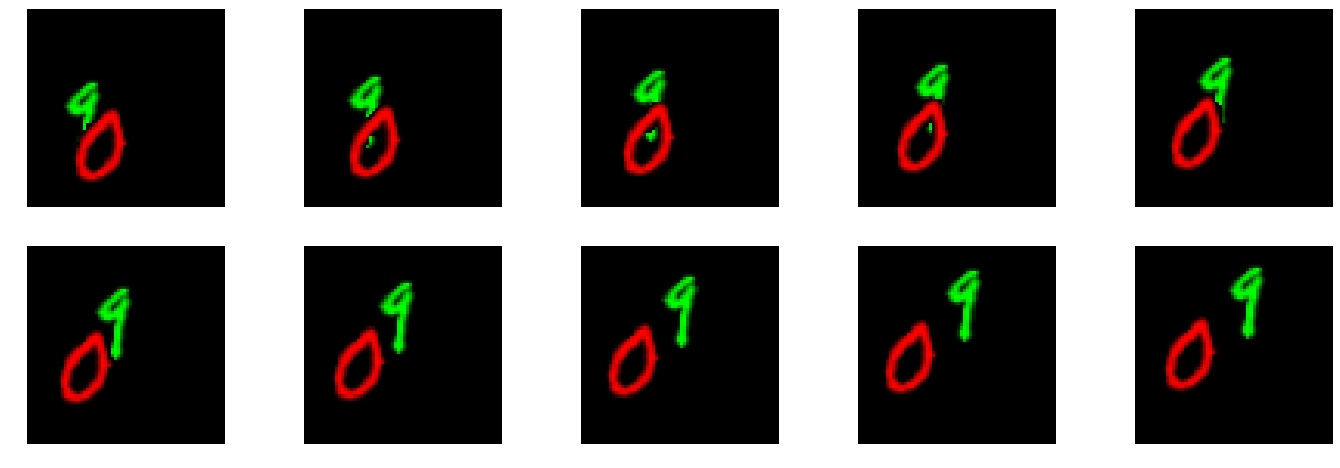

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


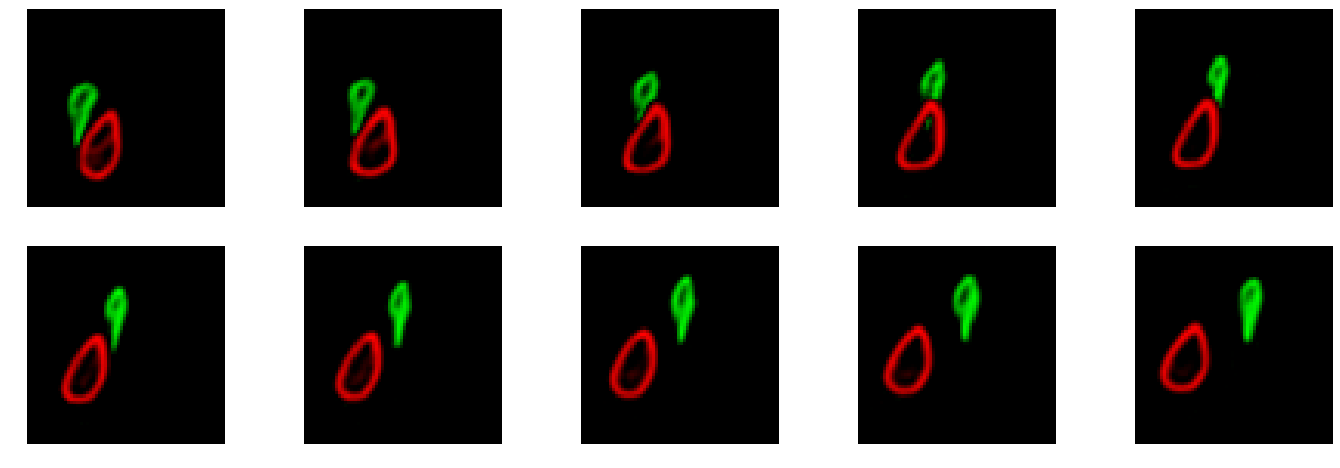

In [8]:
initial_epoch = 0

epochs = 1
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0620_256_Revisited.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 2/40
100/100 [==============================] - 410s 4s/step - loss: 1.3734e-04 - mean_squared_error: 1.3291e-04 - val_loss: 1.7101e-04 - val_mean_squared_error: 1.6658e-04

Epoch 00002: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 3/40
100/100 [==============================] - 408s 4s/step - loss: 1.3518e-04 - mean_squared_error: 1.3075e-04 - val_loss: 1.6785e-04 - val_mean_squared_error: 1.6340e-04

Epoch 00003: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 4/40
100/100 [==============================] - 409s 4s/step - loss: 1.3385e-04 - mean_squared_error: 1.2940e-04 - val_loss: 1.6598e-04 - val_mean_squared_error: 1.6152e-04

Epoch 00004: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 5/40
100/100 [==============================] - 409s 4s/step - loss: 1.3310e-04 - mean_squared_error: 1.2863e-04 - val_loss: 1.6444e-04 - val_mean_squared_error: 1.5996e-04

Epoch 00005: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 6/40
1

100/100 [==============================] - 406s 4s/step - loss: 1.2136e-04 - mean_squared_error: 1.1685e-04 - val_loss: 1.5623e-04 - val_mean_squared_error: 1.5172e-04

Epoch 00035: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 36/40
100/100 [==============================] - 406s 4s/step - loss: 1.2118e-04 - mean_squared_error: 1.1667e-04 - val_loss: 1.5610e-04 - val_mean_squared_error: 1.5159e-04

Epoch 00036: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 37/40
100/100 [==============================] - 408s 4s/step - loss: 1.2083e-04 - mean_squared_error: 1.1633e-04 - val_loss: 1.5585e-04 - val_mean_squared_error: 1.5135e-04

Epoch 00037: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 38/40
100/100 [==============================] - 407s 4s/step - loss: 1.2104e-04 - mean_squared_error: 1.1655e-04 - val_loss: 1.5565e-04 - val_mean_squared_error: 1.5116e-04

Epoch 00038: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 39/40
100/100 

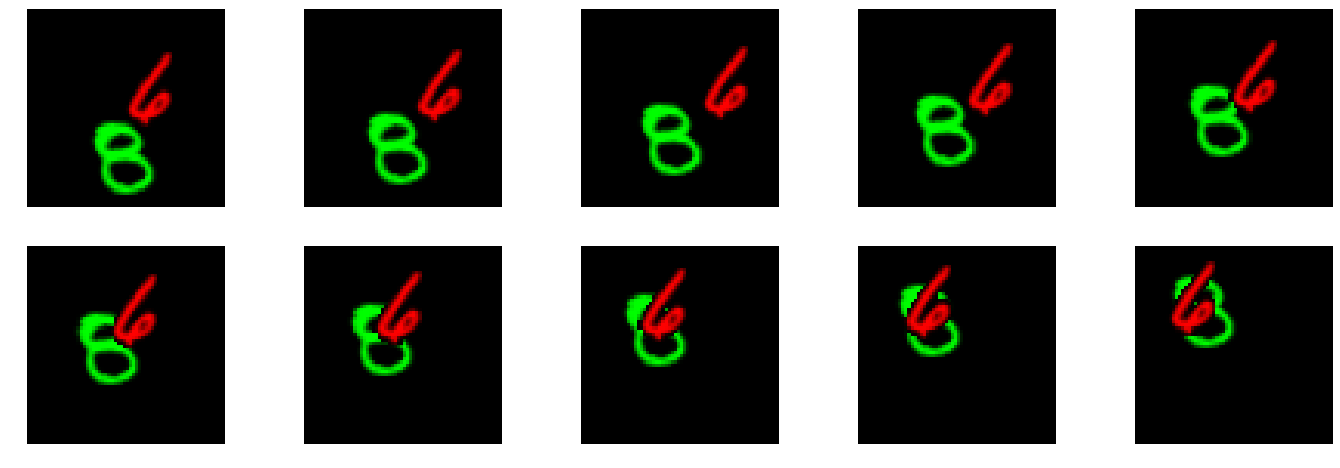

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


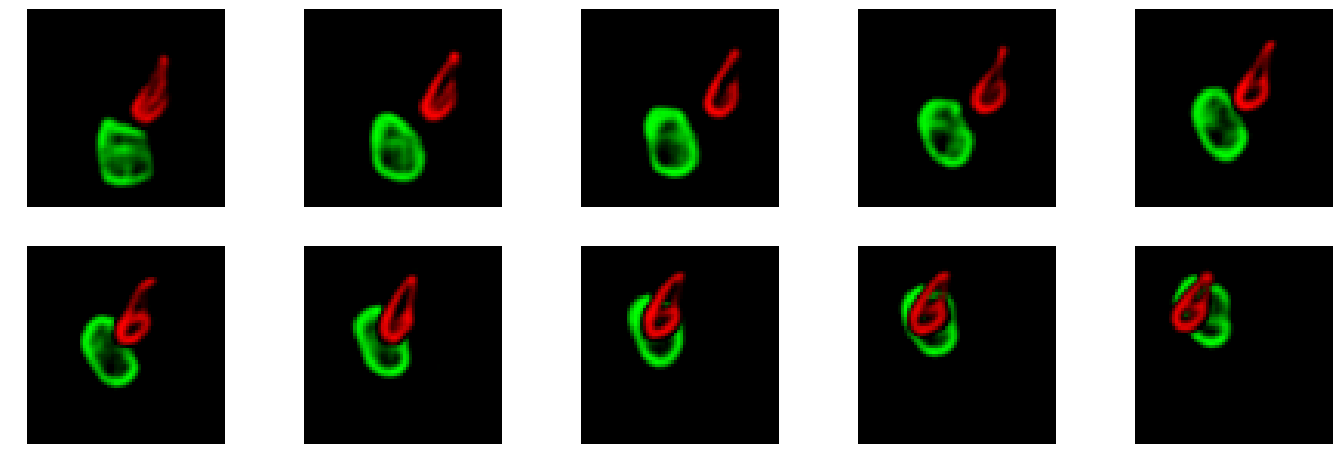

In [9]:
epochs = 40
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0620_256_Revisited.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

In [10]:
opt = optimizers.Adam(lr = 2e-4, decay = 0.0, amsgrad = False)
model.compile(optimizer = opt, loss = 'mse', metrics = ['mse'])

Epoch 41/50
100/100 [==============================] - 413s 4s/step - loss: 1.2031e-04 - mean_squared_error: 1.1583e-04 - val_loss: 1.5604e-04 - val_mean_squared_error: 1.5157e-04

Epoch 00041: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 42/50
100/100 [==============================] - 408s 4s/step - loss: 1.2066e-04 - mean_squared_error: 1.1618e-04 - val_loss: 1.5634e-04 - val_mean_squared_error: 1.5185e-04

Epoch 00042: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 43/50
100/100 [==============================] - 409s 4s/step - loss: 1.2070e-04 - mean_squared_error: 1.1621e-04 - val_loss: 1.5630e-04 - val_mean_squared_error: 1.5181e-04

Epoch 00043: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 44/50
100/100 [==============================] - 410s 4s/step - loss: 1.2041e-04 - mean_squared_error: 1.1591e-04 - val_loss: 1.5619e-04 - val_mean_squared_error: 1.5169e-04

Epoch 00044: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 45

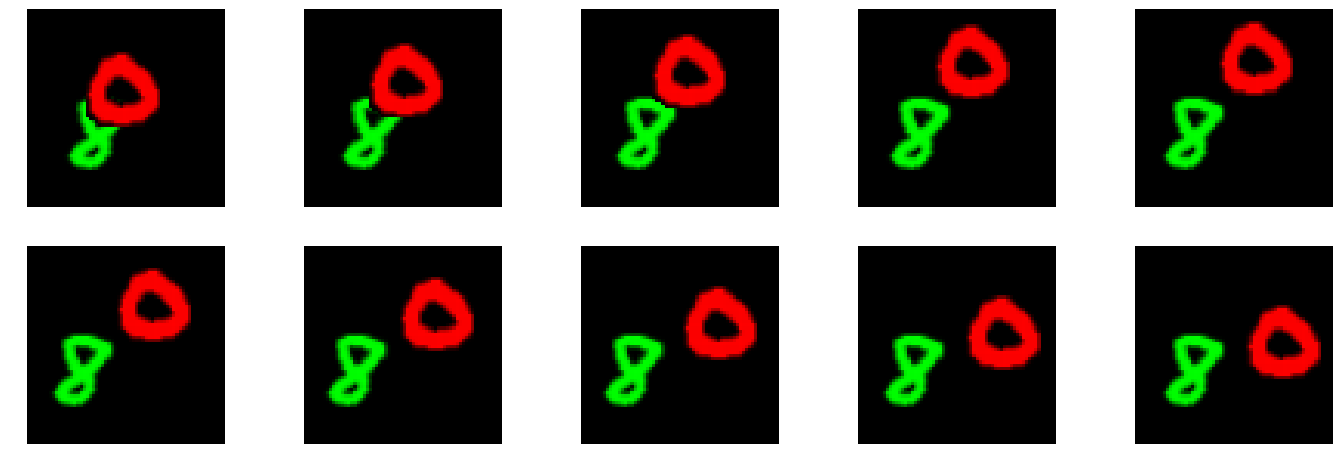

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

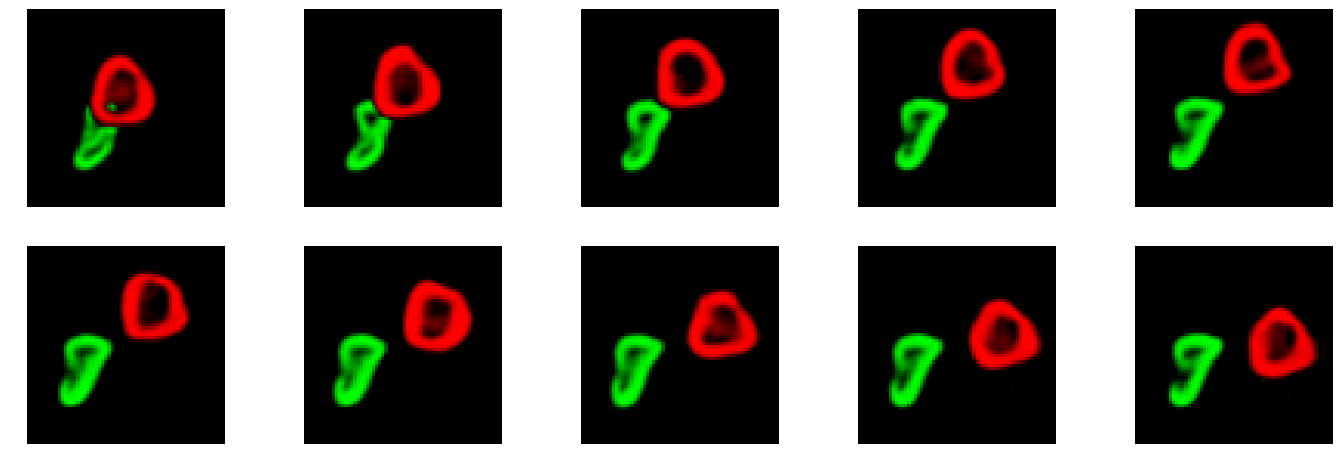

In [11]:
epochs = 50
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0620_256_Revisited.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 51/55
100/100 [==============================] - 406s 4s/step - loss: 1.1928e-04 - mean_squared_error: 1.1474e-04 - val_loss: 1.5573e-04 - val_mean_squared_error: 1.5119e-04

Epoch 00051: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 52/55
100/100 [==============================] - 405s 4s/step - loss: 1.1844e-04 - mean_squared_error: 1.1389e-04 - val_loss: 1.5551e-04 - val_mean_squared_error: 1.5097e-04

Epoch 00052: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 53/55
100/100 [==============================] - 405s 4s/step - loss: 1.1853e-04 - mean_squared_error: 1.1399e-04 - val_loss: 1.5546e-04 - val_mean_squared_error: 1.5092e-04

Epoch 00053: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 54/55
100/100 [==============================] - 405s 4s/step - loss: 1.1813e-04 - mean_squared_error: 1.1359e-04 - val_loss: 1.5519e-04 - val_mean_squared_error: 1.5065e-04

Epoch 00054: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 55

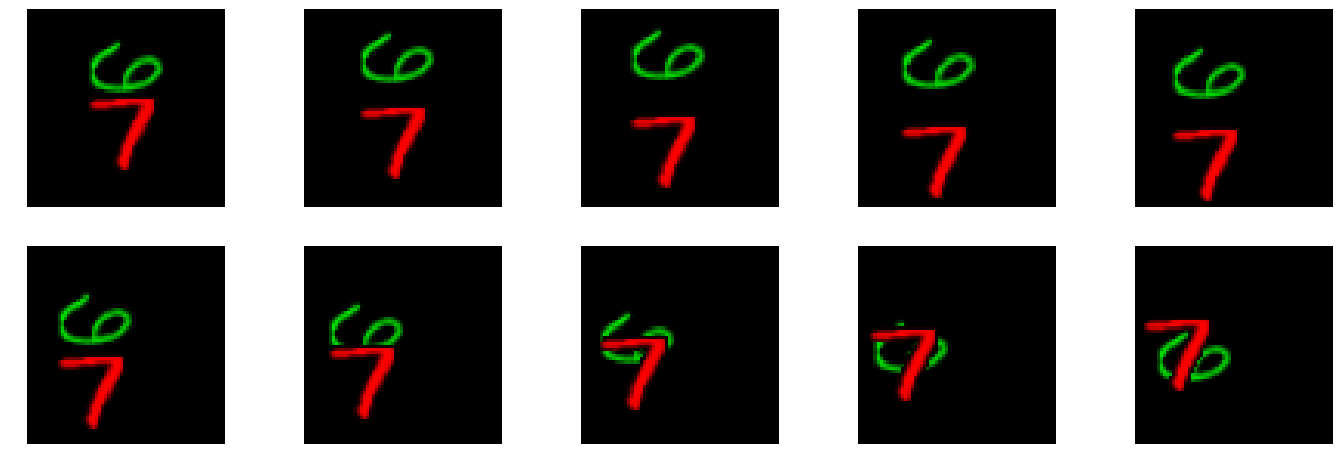

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

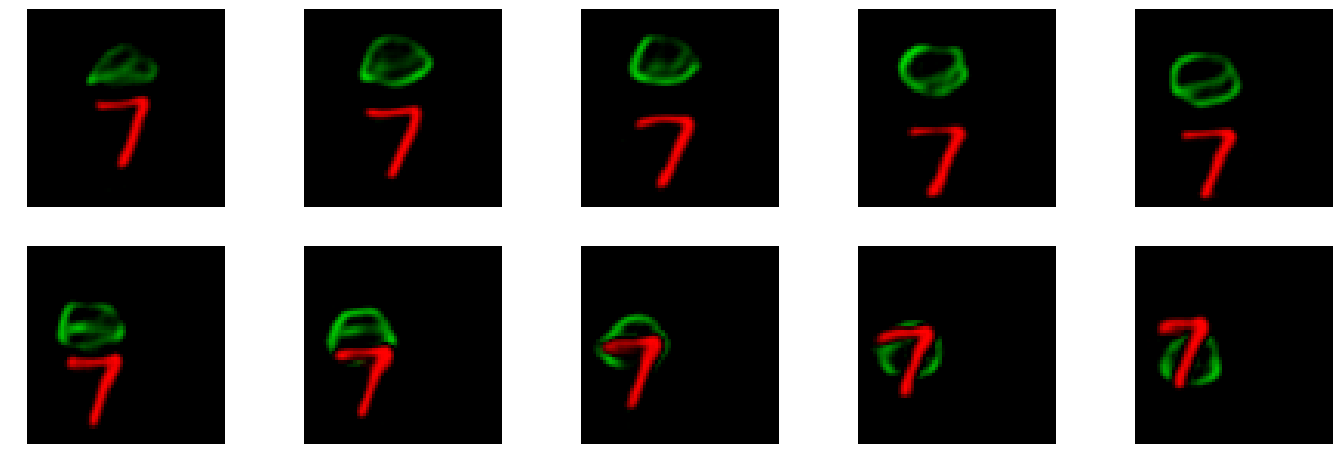

In [12]:
epochs = 55
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0620_256_Revisited.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 56/60
100/100 [==============================] - 406s 4s/step - loss: 1.1800e-04 - mean_squared_error: 1.1346e-04 - val_loss: 1.5506e-04 - val_mean_squared_error: 1.5052e-04

Epoch 00056: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 57/60
100/100 [==============================] - 405s 4s/step - loss: 1.1789e-04 - mean_squared_error: 1.1335e-04 - val_loss: 1.5488e-04 - val_mean_squared_error: 1.5033e-04

Epoch 00057: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 58/60
100/100 [==============================] - 404s 4s/step - loss: 1.1683e-04 - mean_squared_error: 1.1229e-04 - val_loss: 1.5519e-04 - val_mean_squared_error: 1.5065e-04

Epoch 00058: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 59/60
100/100 [==============================] - 405s 4s/step - loss: 1.1689e-04 - mean_squared_error: 1.1235e-04 - val_loss: 1.5472e-04 - val_mean_squared_error: 1.5018e-04

Epoch 00059: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 60

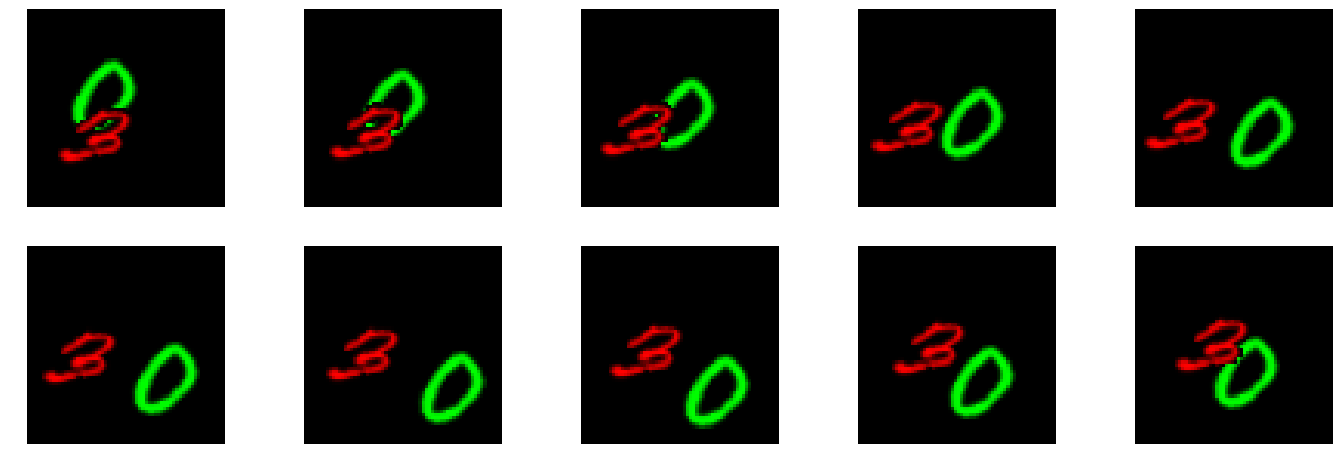

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


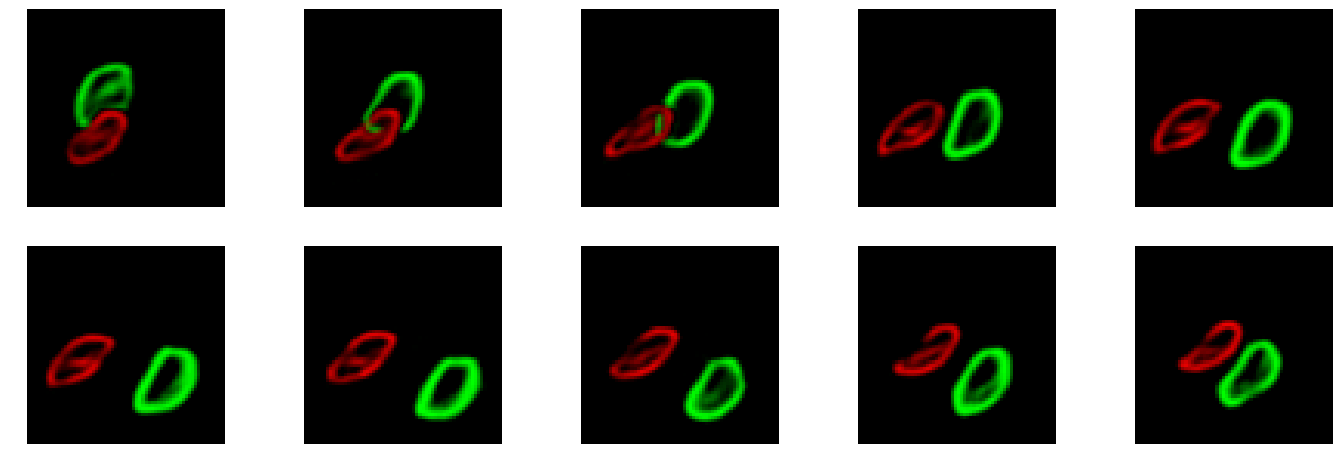

In [14]:
epochs = 60
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0620_256_Revisited.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 61/65
100/100 [==============================] - 412s 4s/step - loss: 1.1603e-04 - mean_squared_error: 1.1149e-04 - val_loss: 1.5456e-04 - val_mean_squared_error: 1.5002e-04

Epoch 00061: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 62/65
100/100 [==============================] - 412s 4s/step - loss: 1.1623e-04 - mean_squared_error: 1.1169e-04 - val_loss: 1.5482e-04 - val_mean_squared_error: 1.5028e-04

Epoch 00062: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 63/65
100/100 [==============================] - 412s 4s/step - loss: 1.1623e-04 - mean_squared_error: 1.1170e-04 - val_loss: 1.5451e-04 - val_mean_squared_error: 1.4997e-04

Epoch 00063: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 64/65
100/100 [==============================] - 411s 4s/step - loss: 1.1568e-04 - mean_squared_error: 1.1114e-04 - val_loss: 1.5467e-04 - val_mean_squared_error: 1.5014e-04

Epoch 00064: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 65

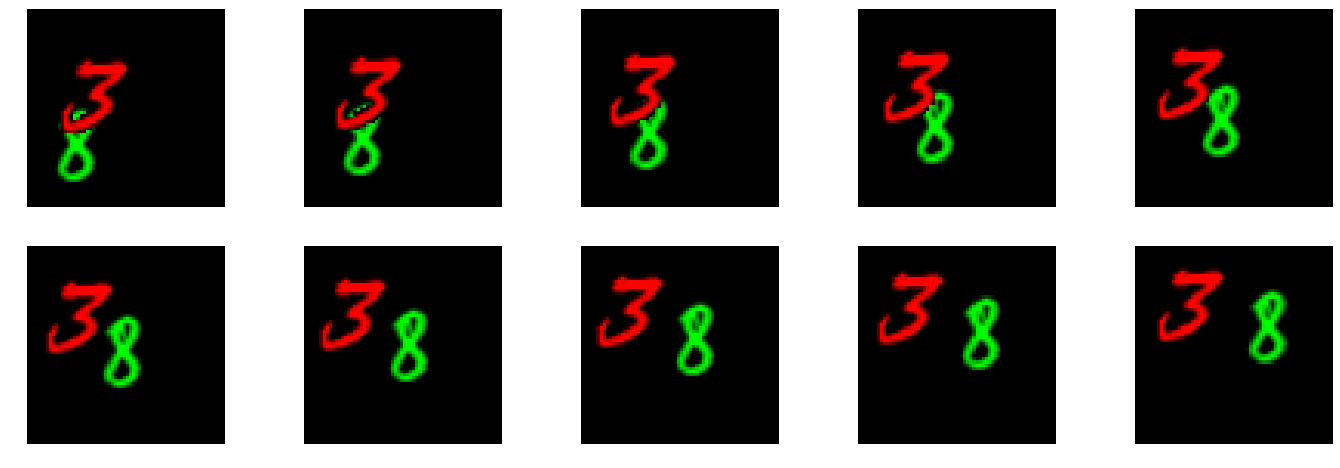

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

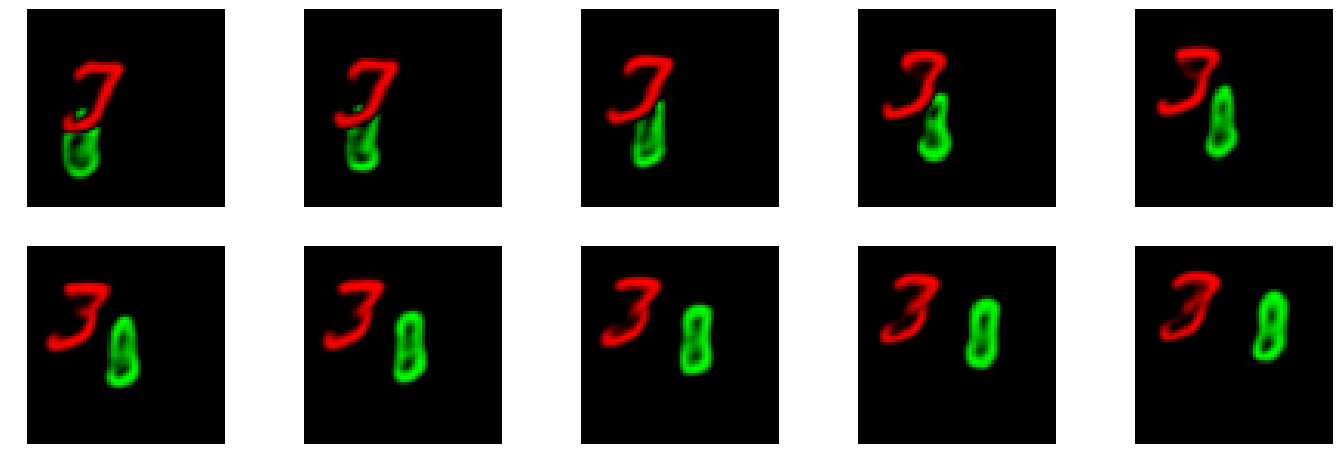

In [16]:
epochs = 65
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0620_256_Revisited.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 66/75
100/100 [==============================] - 413s 4s/step - loss: 1.1501e-04 - mean_squared_error: 1.1049e-04 - val_loss: 1.5448e-04 - val_mean_squared_error: 1.4996e-04

Epoch 00066: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 67/75
100/100 [==============================] - 411s 4s/step - loss: 1.1489e-04 - mean_squared_error: 1.1036e-04 - val_loss: 1.5473e-04 - val_mean_squared_error: 1.5021e-04

Epoch 00067: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 68/75
100/100 [==============================] - 411s 4s/step - loss: 1.1453e-04 - mean_squared_error: 1.1001e-04 - val_loss: 1.5420e-04 - val_mean_squared_error: 1.4968e-04

Epoch 00068: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 69/75
100/100 [==============================] - 412s 4s/step - loss: 1.1451e-04 - mean_squared_error: 1.0999e-04 - val_loss: 1.5417e-04 - val_mean_squared_error: 1.4965e-04

Epoch 00069: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 70

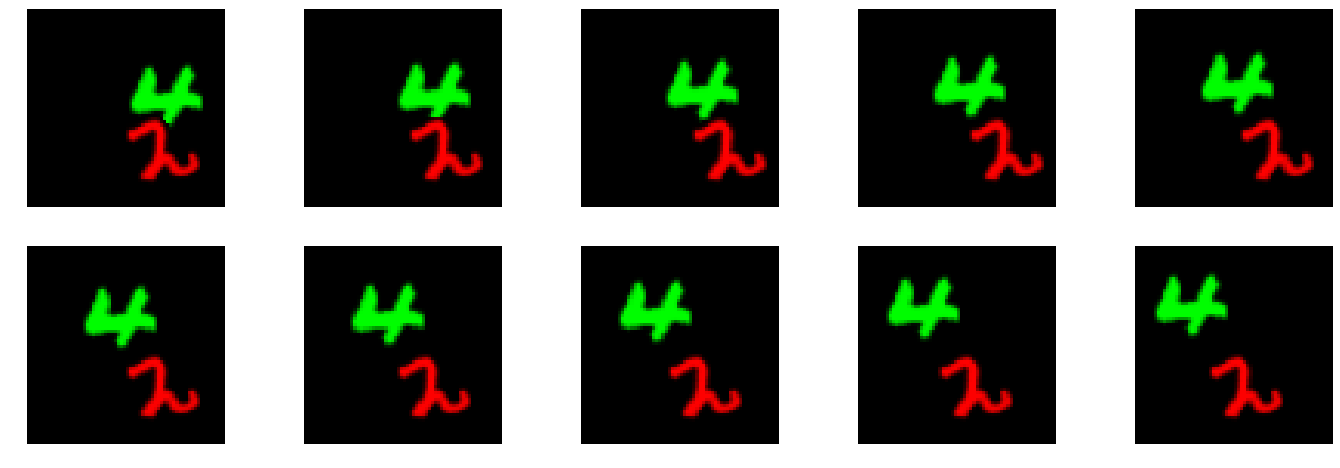

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


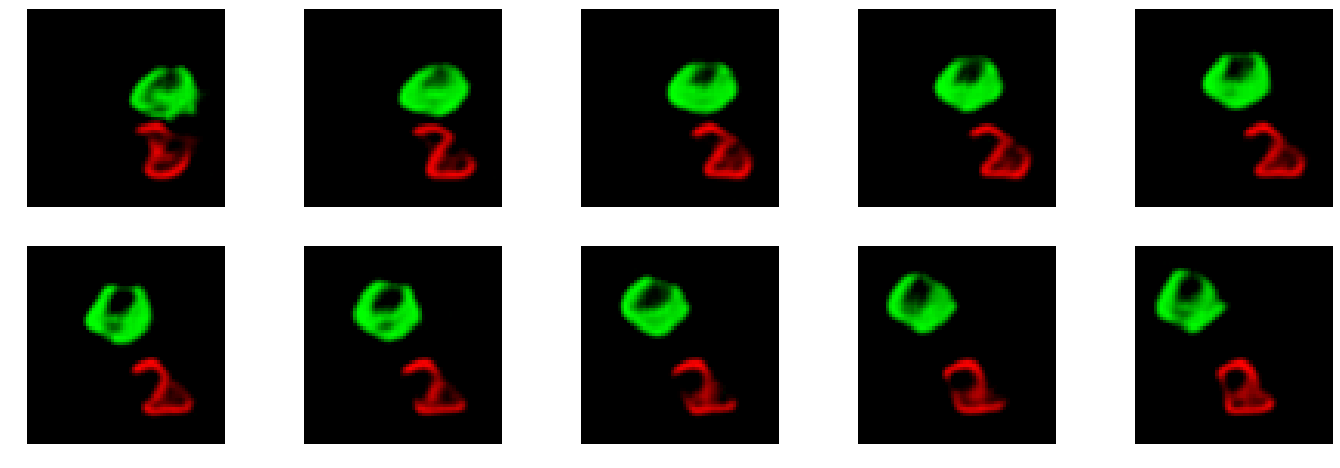

In [17]:
epochs = 75
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0620_256_Revisited.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 76/90
100/100 [==============================] - 410s 4s/step - loss: 1.1230e-04 - mean_squared_error: 1.0780e-04 - val_loss: 1.5337e-04 - val_mean_squared_error: 1.4887e-04

Epoch 00076: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 77/90
100/100 [==============================] - 411s 4s/step - loss: 1.1294e-04 - mean_squared_error: 1.0845e-04 - val_loss: 1.5336e-04 - val_mean_squared_error: 1.4887e-04

Epoch 00077: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 78/90
100/100 [==============================] - 411s 4s/step - loss: 1.1211e-04 - mean_squared_error: 1.0762e-04 - val_loss: 1.5374e-04 - val_mean_squared_error: 1.4926e-04

Epoch 00078: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 79/90
100/100 [==============================] - 412s 4s/step - loss: 1.1204e-04 - mean_squared_error: 1.0756e-04 - val_loss: 1.5350e-04 - val_mean_squared_error: 1.4901e-04

Epoch 00079: saving model to ./models/model0620_256_Revisited.hdf5
Epoch 80

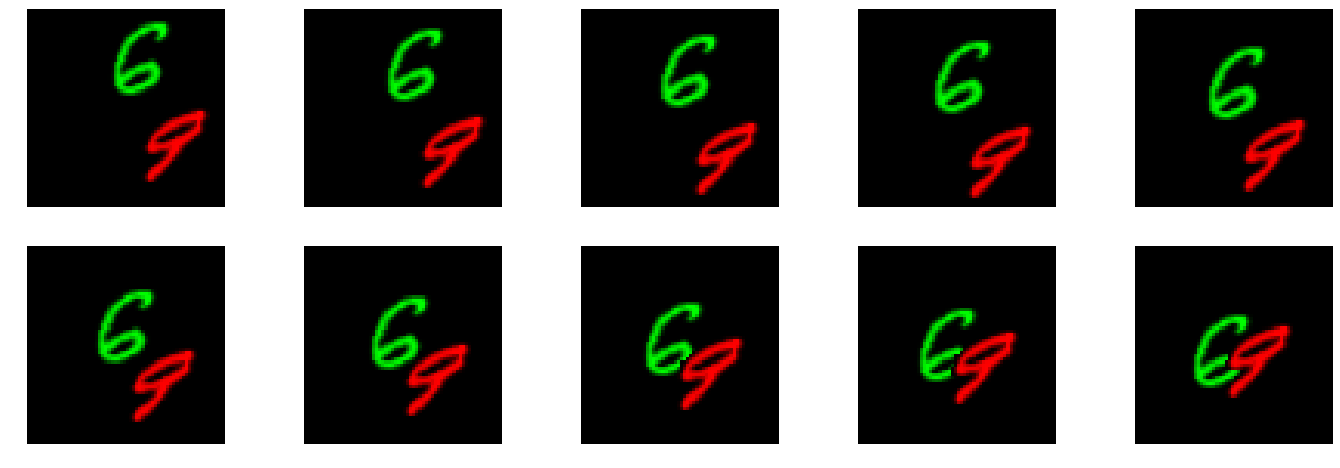

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


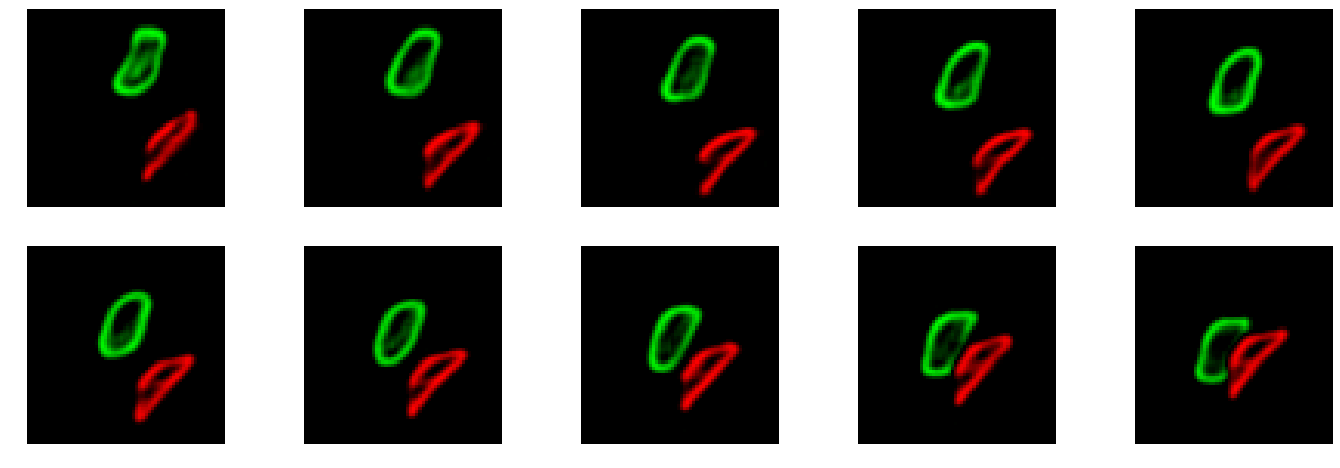

In [21]:
epochs = 90
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0620_256_Revisited.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

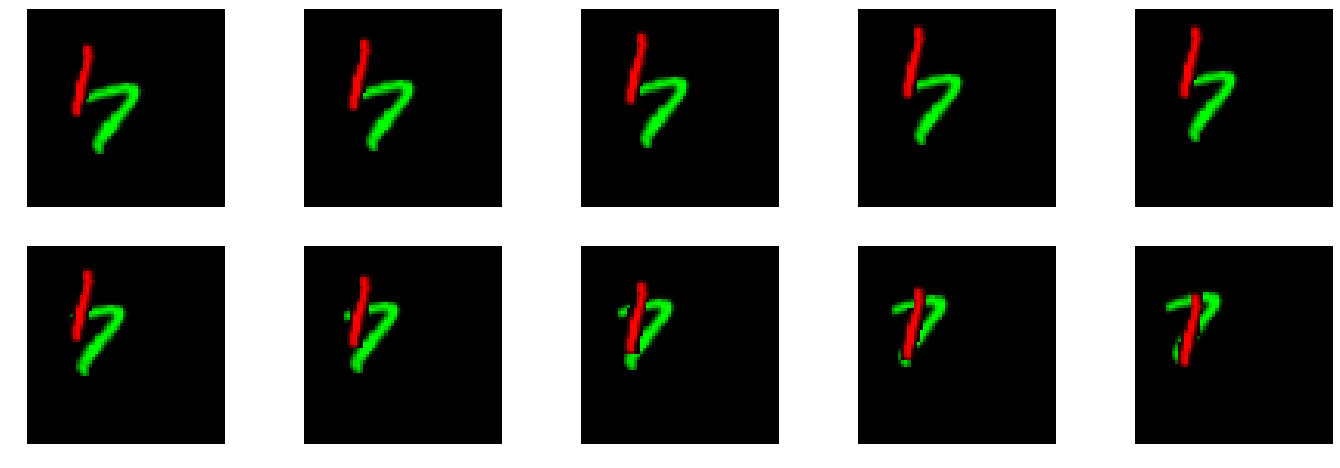

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


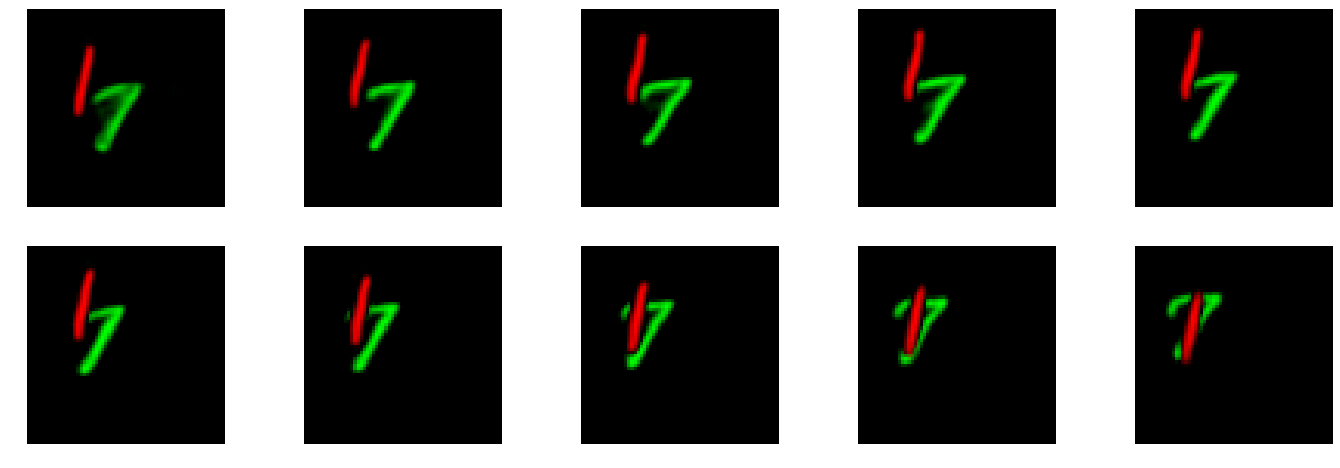

In [20]:
_, _ = show_outputs()

# Feature distribution

In [ ]:
batch1, batch2 = get_train_batch(1)
X_batch = np.concatenate([batch1, batch2])
X_batch = np.reshape(X_batch, (-1, 64, 64, 3))
features = encoder.predict_on_batch(X_batch)
fig = plt.figure(figsize = (24, 16))
for i in range(0, 6):
    fig.add_subplot(3, 2, i+1)
    plt.hist(features[i])
plt.show()

In [ ]:
f_0 = features[0]
f_1 = features[1]
f_2 = features[2]
f_3 = features[3]
f_10 = features[10]

In [ ]:
plt.hist(f_0, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
plt.hist(f_10, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
plt.hist(f_2, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
plt.hist(f_3, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
inputs, answers = get_train_batch(1)
inputs = np.reshape(inputs, (-1, 64, 64, 3))
answers = np.reshape(answers, (-1, 64, 64, 3))
inputs = inputs[:, :, :, :2]
encoded_inputs = encoder.predict_on_batch(inputs)
encoded_inputs = encoded_inputs[None, :, :]
dummy_inputs = np.zeros_like(encoded_inputs, dtype = np.float32)
encoded = np.concatenate([encoded_inputs, dummy_inputs], axis = 1)
features = model.predict_on_batch(encoded)
features = np.reshape(features, (-1, dim))
fig = plt.figure(figsize = (24, 16))
for i in range(0, 6):
    fig.add_subplot(3, 2, i+1)
    plt.hist(features[i])
plt.show()